In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

In [2]:
# # 加载 .npz 文件,其中是通过点击不同区域打好的标注数据
# data = np.load('training_data.npz')
# # 提取数据
# trn_x = data['trnx']
# trn_y= data['trny']
# # 加完整mask图像
# image = cv2.imread('../../data/imgs/0618.png')
# # 转换为RGB格式（opencv读取为BGR）
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# test_x = np.array(image_rgb).reshape(-1,3)


In [3]:
def loadImage(path):
    image = cv2.imread(path)
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image,cv2.COLOR_RGB2LAB)
    return image

def process_image(image):
    data = image.reshape((-1,3))
    return data

In [4]:
def init_centroids(data,K):
    np.random.seed(42)
    indices = np.random.choice(len(data), K, replace=False)
    centroids = data[indices]
    return centroids

def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:,np.newaxis] - centroids,axis=2)
    clusterLabels = np.argmin(distances,axis=1)
    return clusterLabels

def update_centroids(data, clusterLabel, k):
    newCentroid = np.array([data[clusterLabel == i].mean(axis=0) for i in range(k)])
    return newCentroid

def isConverged(oldCentroids, centroids, tolerence = 1e-5):
    return np.linalg.norm(centroids - oldCentroids) < tolerence


In [5]:
def k_means(data, k, iter=100):

    start = time.time()

    centroids = init_centroids(data, k)
    for i in range(iter):
        labels = assign_clusters(data,centroids)
        newCentroids = update_centroids(data,labels,k)
        if isConverged(centroids,newCentroids):
            break
        centroids = newCentroids
        
        print("第", i+1,"次迭代","用时：{0}".format(time.time() - start))
    return labels, centroids

In [6]:
# 显示聚类后的彩色图像
def display_colored_clusters(image, labels, centroids):
    segmented_image = centroids[labels].reshape(image.shape).astype(np.uint8)
    plt.title("Colored Segmentation")
    plt.imshow(segmented_image)
    plt.axis("off")
    plt.show()


In [7]:
# 分离显示每个簇
def display_separated_clusters(image, labels, k):
    h, w, c = image.shape
    fig, axes = plt.subplots(1, k, figsize=(15, 5))
    for i in range(k):
        cluster_image = np.zeros_like(image)
        cluster_image = cluster_image.reshape(-1, 3)
        cluster_image[labels == i] = image.reshape(-1, 3)[labels == i]
        cluster_image = cluster_image.reshape(h, w, c)
        
        axes[i].imshow(cluster_image)
        axes[i].set_title(f"Cluster {i + 1}")
        axes[i].axis("off")
    plt.show()

In [8]:
image_path = '../../data/imgs/0618.png'
k = 2
image = loadImage(image_path)
data = process_image(image)
labels, centroids = k_means(data,k)


第 1 次迭代 用时：0.016598939895629883
第 2 次迭代 用时：0.029150724411010742
第 3 次迭代 用时：0.04065346717834473
第 4 次迭代 用时：0.05303215980529785
第 5 次迭代 用时：0.06307721138000488
第 6 次迭代 用时：0.07569003105163574
第 7 次迭代 用时：0.08692097663879395


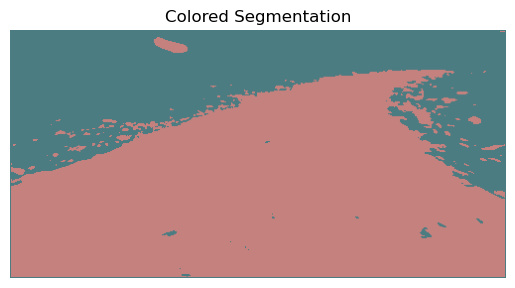

In [9]:
display_colored_clusters(image, labels, centroids)

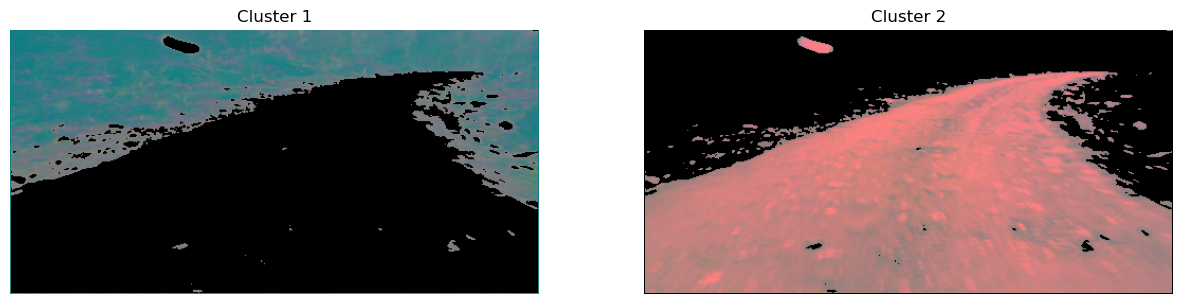

In [10]:
display_separated_clusters(image,labels,k)

In [11]:
# 可视化聚类结果在2D空间
def plot_clusters_2D(data, labels):
    # 使用PCA将数据降维到2D，以便可视化
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    # 绘制聚类结果
    plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', marker='o')
    plt.title("2D Projection of Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

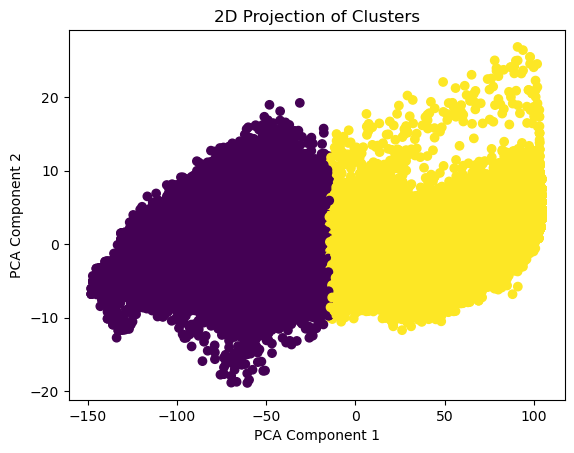

In [12]:
plot_clusters_2D(data,labels)

In [13]:
from sklearn.metrics import silhouette_score

# 计算轮廓系数
silhouette_avg = silhouette_score(data, labels)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.7269454928550253


In [14]:
from sklearn.metrics import calinski_harabasz_score

# 计算Calinski-Harabasz指数
ch_index = calinski_harabasz_score(data, labels)
print(f'Calinski-Harabasz Index: {ch_index}')

Calinski-Harabasz Index: 613420.5188088741


In [15]:
from sklearn.metrics import davies_bouldin_score

# 计算Davies-Bouldin指数
db_index = davies_bouldin_score(data, labels)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.3702781601177738


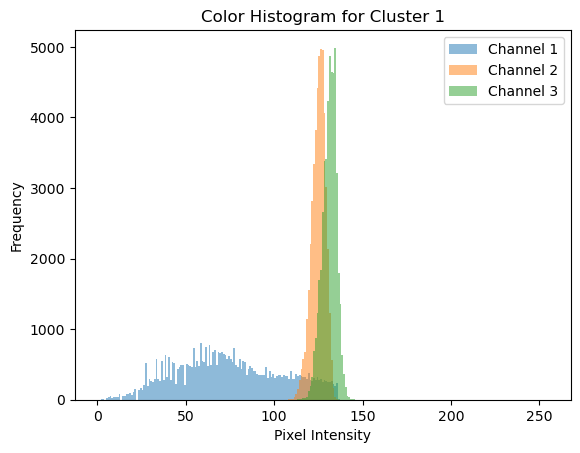

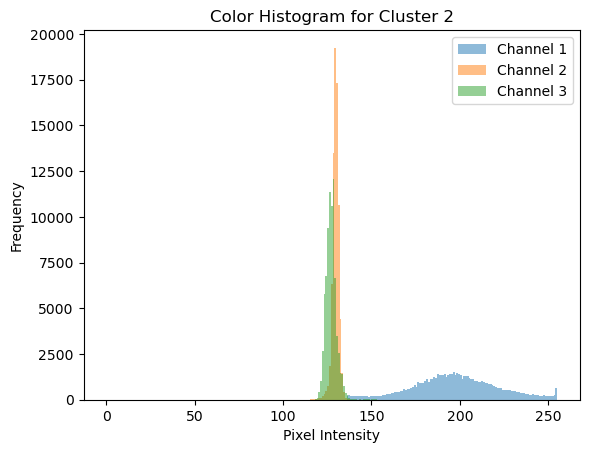

In [16]:
# 绘制每个簇的颜色直方图
for i in range(k):
    cluster_data = data[labels == i]
    plt.figure()
    # 对于每个颜色通道绘制直方图
    for channel in range(3): 
        plt.hist(cluster_data[:, channel], bins=range(256), alpha=0.5, label=f'Channel {channel+1}', histtype='stepfilled')
    plt.title(f'Color Histogram for Cluster {i + 1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [17]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 假设mask是灰度图像
    return mask

# 新增：将mask转换成一维数组
def process_mask(mask):
    mask_data = mask.flatten()
    return mask_data

In [18]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, recall_score, precision_score
# 加载并处理mask
mask_path = '../../data/imgs/mask0618.png' 
mask = load_mask(mask_path)
mask_data = process_mask(mask)

# 确保mask和聚类结果具有相同的尺寸
assert mask_data.shape == labels.shape, "Mask and clustering results must have the same size."

# 如果mask和聚类结果的类别编号不一致，可能需要进行映射
# 这里假设类别编号是连续的，并且从0开始
unique_labels = np.unique(labels)
unique_masks = np.unique(mask_data)
if not np.array_equal(unique_labels, unique_masks):
    # 创建一个映射，将聚类标签映射到mask标签
    mapping = {}
    for i, label in enumerate(unique_labels):
        # 找到最接近的mask标签
        closest_mask_label = unique_masks[np.argmin(np.abs(unique_masks - label))]
        mapping[label] = closest_mask_label
    # 应用映射
    mapped_labels = np.vectorize(mapping.get)(labels)
else:
    mapped_labels = labels

# 计算各种度量指标
jaccard = jaccard_score(mask_data, mapped_labels, average='macro')
f1 = f1_score(mask_data, mapped_labels, average='macro')
accuracy = accuracy_score(mask_data, mapped_labels)
recall = recall_score(mask_data, mapped_labels, average='macro')
precision = precision_score(mask_data, mapped_labels, average='macro')

# 打印结果
print(f'Jaccard Score: {jaccard}')
print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

Jaccard Score: 0.9127902113203195
F1 Score: 0.9543218405321835
Accuracy: 0.956272
Recall: 0.9490672447645221
Precision: 0.9618660611972278
